In [1]:
# 1 FILTER DATAFRAME USING THE SAME BOUNDING BOX YOU HAVE USED FOR QUERYING THE API
# 2 FETCH THE IMAGE IDS IN THE SAME BOUNDING BOX WITH MAPILLARY
# 3 MATCH THE IMAGE IDS WITH THE EDGE IDS:
#### - ADD EXTRA POINTS BETWEEN EVERY EDGE START AND END (edge points) 
#### - Construct A BALL TREE WITH THE EDGE POINTS (https://stackoverflow.com/questions/56862277/interpreting-sklearn-haversine-outputs-to-kilometers)
#### - Query the Ball tree using the simage points (for each image, find the closest point)
#### - Remove matches such that the distance is larger than 50 meters
#### - Build a dictionary image_id --> edge_id

In [4]:
#Load shapefile

my_shapefile_path = "koebenhavn.shp"
my_shp = gpd.read_file(my_shapefile_path)
print(my_shp)

          edgeUID      osmId  \
0       174207903   33287608   
1       174208208   26606437   
2       174297915   33617063   
3       174315778  201761225   
4       174318013  204336817   
...           ...        ...   
301806  174470053  579058980   
301807  174490815  905243261   
301808  174475039  523529477   
301809  174498791  358311842   
301810  174486458  960137697   

                                                 geometry  
0       LINESTRING (12.21101 55.53315, 12.21102 55.53331)  
1       LINESTRING (12.21088 55.53637, 12.21084 55.53613)  
2       LINESTRING (12.12414 55.54850, 12.12640 55.54776)  
3       LINESTRING (12.19696 55.59202, 12.19650 55.59186)  
4       LINESTRING (12.22279 55.57121, 12.22276 55.57112)  
...                                                   ...  
301806  LINESTRING (12.56211 55.64295, 12.56211 55.642...  
301807  LINESTRING (12.56742 55.68013, 12.56750 55.68019)  
301808  LINESTRING (12.55413 55.66424, 12.55396 55.66422)  
301809  LINESTR

In [3]:
import geopandas as gpd
import matplotlib.pylab as plt
from shapely.geometry import Polygon
import numpy as np
import itertools
from operator import itemgetter
import pandas as pd
from shapely.geometry import Point
from scipy.spatial import cKDTree
from shapely.geometry import Point, LineString
import requests as rq
import json
from sklearn.neighbors import BallTree
from dbfread import DBF

In [9]:
#Access to Mapillary API

clienttoken = "MLY|9628299323862586|367193f1276e3145e7872e973f7907f8"
#URL for getting only images within the chosen boundaries
url = f"https://graph.mapillary.com/images?access_token={clienttoken}&fields=id,computed_geometry&bbox=12.539467,55.660144,12.563714,55.675971"

response = rq.get(url)

rqcon = response.content

#Decode in order to get rid og bytestring 
deco = rqcon.decode()

result = json.loads(deco)
images = list(result.values())[0]

#Loop to get list of coordinates and ID's 
#Not all images has coordinates so the try/except only gets the ID's which has coordinates
coor = []
ID = []
for i in range(0,len(images)):
    try:
        coord = images[i]["computed_geometry"]["coordinates"]
        coor.append(coord)
        id = str(images[i]["id"])
        ID.append(id)
    except KeyError:
        continue
#print(coor[0][0])
#print(ID)
new_coor =[] 
for i in range(0,len(coor)):
    vupti = coor[i][0]




#Get coordinates as Shapely Points 
points = []

for i in range(0,len(coor)):
    point = Point(coor[i])
    points.append(point)

#print(points)

#Check if Id and points are the same length
#print(len(ID))
#print(len(points))


#Create geopandas dataframe from ID's and points
dataframepoints = {"ID": ID, "geometry": points}
df_points = gpd.GeoDataFrame(dataframepoints)
num_images = len(df_points)

print(df_points)


                    ID                   geometry
0     1257495244665875  POINT (12.55857 55.66659)
1     1269044746825758  POINT (12.56377 55.67526)
2     1669497853240610  POINT (12.54494 55.67536)
3     1260996954764990  POINT (12.55927 55.66557)
4     4171681666221823  POINT (12.54084 55.66143)
...                ...                        ...
1975  1249533882130889  POINT (12.54806 55.66823)
1976  2129744093846845  POINT (12.54340 55.66605)
1977  2142296539403267  POINT (12.54716 55.66566)
1978  3208213752790535  POINT (12.56336 55.66980)
1979  5903950169692533  POINT (12.56041 55.66250)

[1980 rows x 2 columns]


In [6]:
#Set boundaries
bound = Polygon([(12.539467, 55.660144), (12.539467, 55.675971),(12.563714, 55.675971), (12.563714, 55.660144)])

#Find the values from the shapefile that is within the boundaries
TF = my_shp.within(bound)


edges_within_bound_index = TF[TF].index

geo_tag = my_shp["geometry"][TF.values]


emp_list = []
for i in range(0,len(edges_within_bound_index)):
    segment_list = []
    for i in list(geo_tag.iloc[i].coords):
        segment_list.append(list(i))
    #if 2 < len(segment_list):
    #    continue
    emp_list.append(segment_list)



#Create dataframe 
data1 = {"ID": my_shp["edgeUID"][TF.values], "geometry": geo_tag}
df_lines = gpd.GeoDataFrame(data1)
print(df_lines)


#df_lines = gpd.GeoDataFrame(TF)



               ID                                           geometry
47      174472823  LINESTRING (12.54255 55.66452, 12.54272 55.66479)
188     174472925  LINESTRING (12.54329 55.66718, 12.54352 55.667...
515     174477311  LINESTRING (12.56242 55.67385, 12.56234 55.67394)
845     174474161  LINESTRING (12.54380 55.67105, 12.54376 55.67109)
849     174477032  LINESTRING (12.56357 55.67126, 12.56361 55.67128)
...           ...                                                ...
301660  174474898  LINESTRING (12.54812 55.66269, 12.54809 55.66274)
301676  174475046  LINESTRING (12.55384 55.66429, 12.55399 55.66431)
301682  174475045  LINESTRING (12.55396 55.66422, 12.55400 55.664...
301756  174475042  LINESTRING (12.55399 55.66431, 12.55398 55.664...
301808  174475039  LINESTRING (12.55413 55.66424, 12.55396 55.66422)

[2442 rows x 2 columns]


<Axes: >

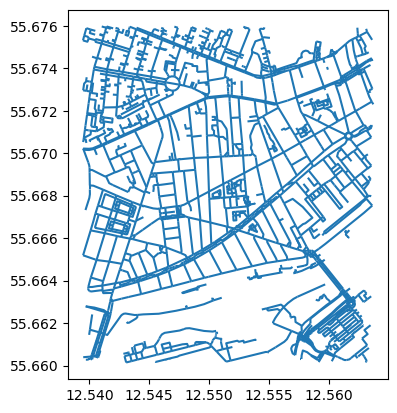

In [10]:

df_lines["geometry"].plot()

/tmp/ipykernel_162093/3281745053.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df_lines["geometry"].buffer(0.0001, cap_style = 2).plot(ax=ax,alpha=0.5)   #With Buffer


<Axes: >

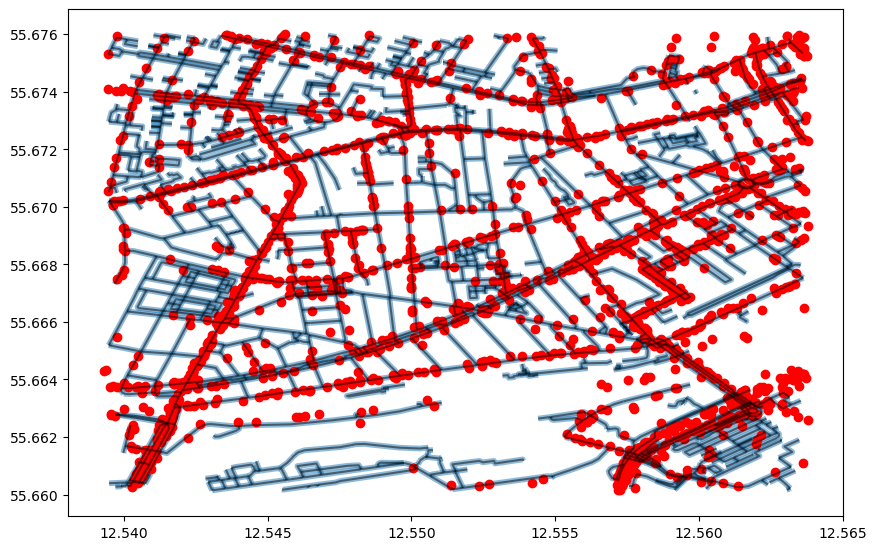

In [11]:
fig, ax = plt.subplots(figsize = (10,10))
df_lines["geometry"].buffer(0.0001, cap_style = 2).plot(ax=ax,alpha=0.5)   #With Buffer
#df_lines["geometry"].plot(ax=ax,alpha=0.5)  #W/o buffer
df_lines["geometry"].plot(ax=ax,alpha=0.5,color = "k")
df_points["geometry"].plot(ax=ax,color = "r")



## Non-assigned Pictures

/tmp/ipykernel_162093/898194467.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df_polygons["geometry"] = df_polygons["geometry"].buffer(0.0001, cap_style = 2)
/tmp/ipykernel_162093/898194467.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  df_lines["geometry"].buffer(0.0001, cap_style = 2).plot(ax=ax,alpha=0.5)


264


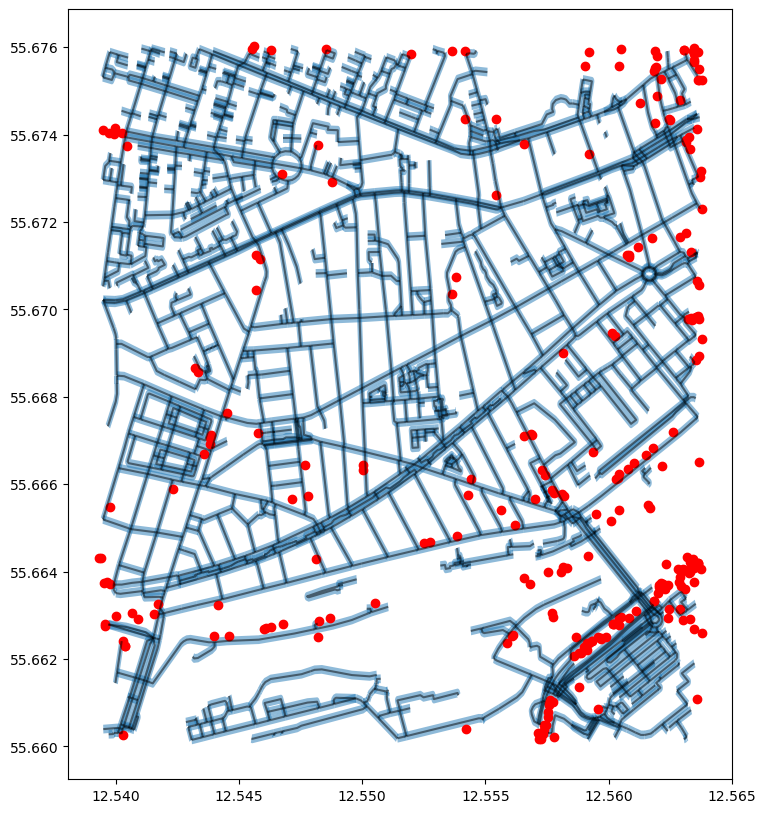

In [12]:
df_polygons = df_lines.copy()
df_polygons.crs = df_lines.crs
df_points.crs = df_lines.crs
df_polygons["geometry"] = df_polygons["geometry"].buffer(0.0001, cap_style = 2)

pointInPoly = gpd.sjoin(df_points, df_polygons, how='left',predicate='within') 

fig, ax = plt.subplots(figsize = (10,10))
df_lines["geometry"].buffer(0.0001, cap_style = 2).plot(ax=ax,alpha=0.5)
df_lines["geometry"].plot(ax=ax,alpha=0.5,color = "k")
pointInPoly[pointInPoly['index_right'].isna()].plot(ax=ax,color = "r")

print(len(pointInPoly[pointInPoly['index_right'].isna()]))


In [13]:
pointInPoly

,ID_left,geometry,index_right,ID_right
0,1257495244665875,POINT (12.55857 55.66659),34273.0,174475749.0
1,1269044746825758,POINT (12.56377 55.67526),NaN,NaN
2,1669497853240610,POINT (12.54494 55.67536),57302.0,174474613.0
2,1669497853240610,POINT (12.54494 55.67536),216103.0,174474619.0
3,1260996954764990,POINT (12.55927 55.66557),111090.0,174475738.0
...,...,...,...,...
1976,2129744093846845,POINT (12.54340 55.66605),198801.0,174472874.0
1977,2142296539403267,POINT (12.54716 55.66566),NaN,NaN
1978,3208213752790535,POINT (12.56336 55.66980),NaN,NaN
1979,5903950169692533,POINT (12.56041 55.66250),172943.0,174475577.0


<Axes: >

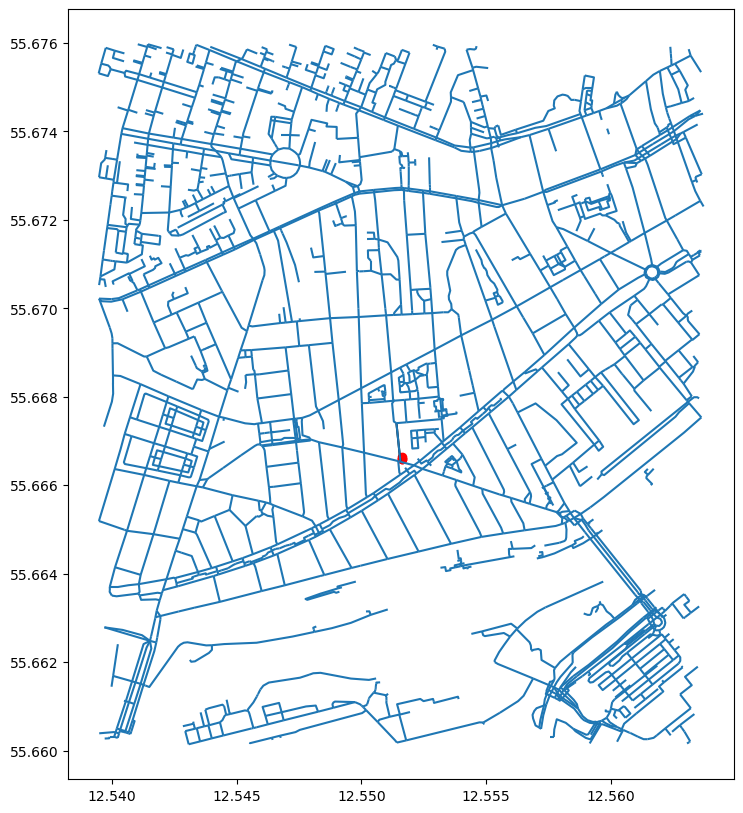

In [14]:
fig, ax = plt.subplots(figsize = (10,10))
test = pointInPoly[pointInPoly.ID_right==174475028].copy()
df_lines[df_lines.ID==174475028].plot(ax=ax, color = "k")
df_lines.plot(ax=ax)
test["geometry"].plot(color = "r",ax=ax)

(55.660144, 55.675971)

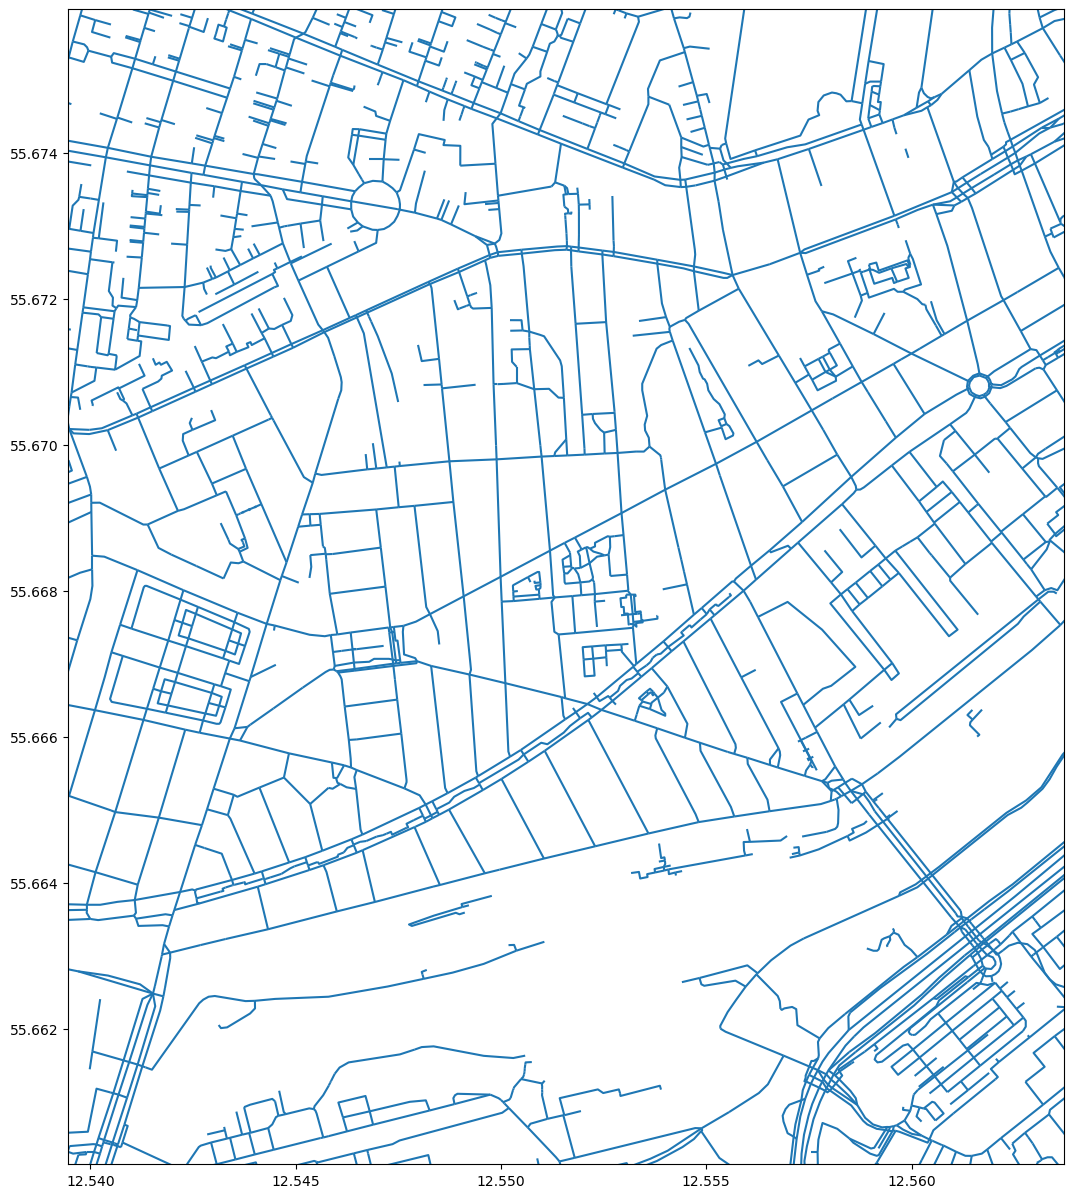

In [15]:
fig, ax = plt.subplots(1, 1, figsize = (15,15))
my_shp.plot(ax = ax)

ax.set_xlim(12.539467, 12.563714)
ax.set_ylim(55.660144, 55.675971)

In [16]:
#Shapefile gives edgeUID, osmId and geometry 
shp = "/home/s214604/data_from_laura/all_edges_monthly_jan_2022-dec_2022_ped/7f42d69dd7bd00b04081b9cbd0d05ab4e5f87353dcd7364c34b8e7c74d42109d-1676891223740.shp"
strava_shape = gpd.read_file(shp)
#print(strava_shape)

#csv-file gives edge_uid, actitivity type, date, total_trip_count etc. 
strava_csv = pd.read_csv("/home/s214604/data_from_laura/all_edges_monthly_jan_2022-dec_2022_ped/7f42d69dd7bd00b04081b9cbd0d05ab4e5f87353dcd7364c34b8e7c74d42109d-1676891223740.csv")
#print(strava_csv)

#dbf-file gives edgeUID and osmId 
dbf = DBF('/home/s214604/data_from_laura/all_edges_monthly_jan_2022-dec_2022_ped/7f42d69dd7bd00b04081b9cbd0d05ab4e5f87353dcd7364c34b8e7c74d42109d-1676891223740.dbf')
frame = pd.DataFrame(iter(dbf))
#print(frame)

#textfile ???
file1 = open("/home/s214604/data_from_laura/all_edges_monthly_jan_2022-dec_2022_ped/7f42d69dd7bd00b04081b9cbd0d05ab4e5f87353dcd7364c34b8e7c74d42109d-1676891223740.txt","r")
#print(file1)

In [17]:

#print(strava_csv)

csv_df = {"ID": strava_csv["edge_uid"], "Activity": strava_csv["total_trip_count"]}
# "Month": strava_csv["month"]
csv_df = pd.DataFrame(data=csv_df)
csv_df = csv_df.dropna(subset=["ID"])
csv_df["Summed activity"] = csv_df.groupby("ID")["Activity"].transform("sum")
collapsed_df = csv_df.drop_duplicates(subset=["ID"], keep="first")
filtered_df = collapsed_df[collapsed_df["ID"].isin(df_lines["ID"])]

activity_df = pd.DataFrame({"ID": filtered_df["ID"], "Activity": filtered_df["Summed activity"]})

list_ID_ac = activity_df["ID"].tolist()
list_ID_line = df_lines["ID"].tolist()
print((len(list_ID_ac),len(list_ID_line)))

print(activity_df)


(1901, 2442)
                ID  Activity
3552     174476152      1260
4284     174476138       725
5205     174472857     11885
5217     174475361     11190
6086     174474204      5855
...            ...       ...
1662088  174475728     11890
1662100  174476604     10050
1664757  174474907       565
1665491  174474571      4670
1665515  174476242      2935

[1901 rows x 2 columns]


In [18]:
merged_df = pd.merge(pointInPoly, activity_df, left_on="ID_right", right_on="ID")
merged_df

,ID_left,geometry,index_right,ID_right,ID,Activity
0,1257495244665875,POINT (12.55857 55.66659),34273.0,174475749.0,174475749,7660
1,1385937608448753,POINT (12.55925 55.66691),34273.0,174475749.0,174475749,7660
2,2941102676173763,POINT (12.55885 55.66673),34273.0,174475749.0,174475749,7660
3,3028750894023372,POINT (12.55923 55.66695),34273.0,174475749.0,174475749,7660
4,3094644117528125,POINT (12.55908 55.66682),34273.0,174475749.0,174475749,7660
...,...,...,...,...,...,...
2470,2565700917057344,POINT (12.55764 55.67202),12287.0,174476880.0,174476880,3255
2471,1452489231762873,POINT (12.55539 55.67398),176797.0,174476631.0,174476631,4170
2472,1631386123716719,POINT (12.55139 55.67499),65224.0,174476379.0,174476379,5
2473,1631386123716719,POINT (12.55139 55.67499),171595.0,174476385.0,174476385,310


In [19]:
isnull = merged_df.index[merged_df["Activity"].isnull()].tolist()

isnull

[]

In [20]:
'''
result = merged_df.drop_duplicates(['ID_left'],keep='first')
result
reset = result.reset_index()
reset.pop("index")
reset
#dataframe2 = reset.rename(columns = {"ID_left": "Image ID","geometry": "Image coordinate","index_right": "Segment index","ID_right": "Segment ID", "ID": "Segment ID","Activity": "Activity"}, inplace=True)
#print(dataframe2)
'''

'\nresult = merged_df.drop_duplicates([\'ID_left\'],keep=\'first\')\nresult\nreset = result.reset_index()\nreset.pop("index")\nreset\n#dataframe2 = reset.rename(columns = {"ID_left": "Image ID","geometry": "Image coordinate","index_right": "Segment index","ID_right": "Segment ID", "ID": "Segment ID","Activity": "Activity"}, inplace=True)\n#print(dataframe2)\n'

## Data Manipulation

In [149]:
list_image_id = pointInPoly["ID_left"].tolist()
list_image_id_new = list_image_id
list_image_id_new = [eval(i) for i in list_image_id_new]
list_image_id = [eval(i) for i in list_image_id]
#print(list_image_id_new)

clienttoken = "MLY|9628299323862586|367193f1276e3145e7872e973f7907f8"
#URL for getting only images within the chosen boundaries


ID_image = []
detection = []

ID_image = []
detection = []

for i in range(0,len(list_image_id_new)):
    url = f"https://graph.mapillary.com/{list_image_id_new[i]}/detections?access_token={clienttoken}&fields=image,value"
    response = rq.get(url)
    rqcon = response.content
    #Decode in order to get rid of bytestring 
    deco = rqcon.decode()
    result = json.loads(deco)
    images = list(result.values())[0]
    #print(len(images))
    #print(images)
    for i in range(0,len(images)):
        try:
            val = str(images[i]["value"])
            detection.append(val)
            ID = str(images[i]["image"]["id"])
            ID_image.append(ID)
        except KeyError:
            continue
            
#list of objects to remove 
vd = ["void--dynamic","void--static","void--unlabeled"]

indices_to_remove = [i for i, string in enumerate(detection) if string in vd]
new_string_list = []
new_index_list = []
for i in range(len(detection)):
    if i not in indices_to_remove:
        new_string_list.append(detection[i])
        new_index_list.append(ID_image[i])
    



#print((len(new_index_list),len(new_string_list)))
dataframevalue = {"ID": new_index_list, "Detection": new_string_list}
df_imagess = gpd.GeoDataFrame(dataframevalue)
#print(df_imagess)
            
dict_image = df_imagess.groupby('ID')['Detection'].agg(list).to_dict()
#print(dict_image)
#print(dict_image)
dict_image2 = list(dict_image.values())
#print(dict_image2)
dict_image3 =sum(dict_image2, [])
#print(dict_image3)

def count_occurrence(lst):
    count = {}
    for item in lst:
        if item in count:
            count[item] += 1
        else:
            count[item] = 1
    return count

unique_occurrences = count_occurrence(dict_image3)

detections_per_image = []
dict_image_ids = []
image_ids = list(dict_image.keys())
for id in image_ids:
    dict_image_ids.append({'image_id': '{}'.format(id)})
    detections = count_occurrence(dict_image[id])
    detections_per_image.append(detections)
df_detections = pd.DataFrame.from_dict(detections_per_image)
df_image_ids = pd.DataFrame.from_dict(dict_image_ids)

#print(pd.DataFrame.from_dict(detections_per_image))
print(pd.DataFrame.from_dict(dict_image_ids))
print(pd.concat([df_image_ids,df_detections], axis = 1))

    

sorted_unique_occurrences = sorted(unique_occurrences.items(), key=lambda x:x[1])
#print(sorted_unique_occurrences)

              image_id
0     1225822924515253
1     1226142838206258
2     1226210394958346
3     1227881311189698
4     1228109880954282
...                ...
1559  8688376787902180
1560  8751111771627232
1561  8758270937576935
1562  9079294525421585
1563  9133931299965451

[1564 rows x 1 columns]
              image_id  object--sign--store  object--street-light  \
0     1225822924515253                 22.0                   2.0   
1     1226142838206258                  2.0                   2.0   
2     1226210394958346                  6.0                  12.0   
3     1227881311189698                  6.0                  21.0   
4     1228109880954282                  1.0                   2.0   
...                ...                  ...                   ...   
1559  8688376787902180                  NaN                  12.0   
1560  8751111771627232                  6.0                  15.0   
1561  8758270937576935                  NaN                   5.0   
1562  907

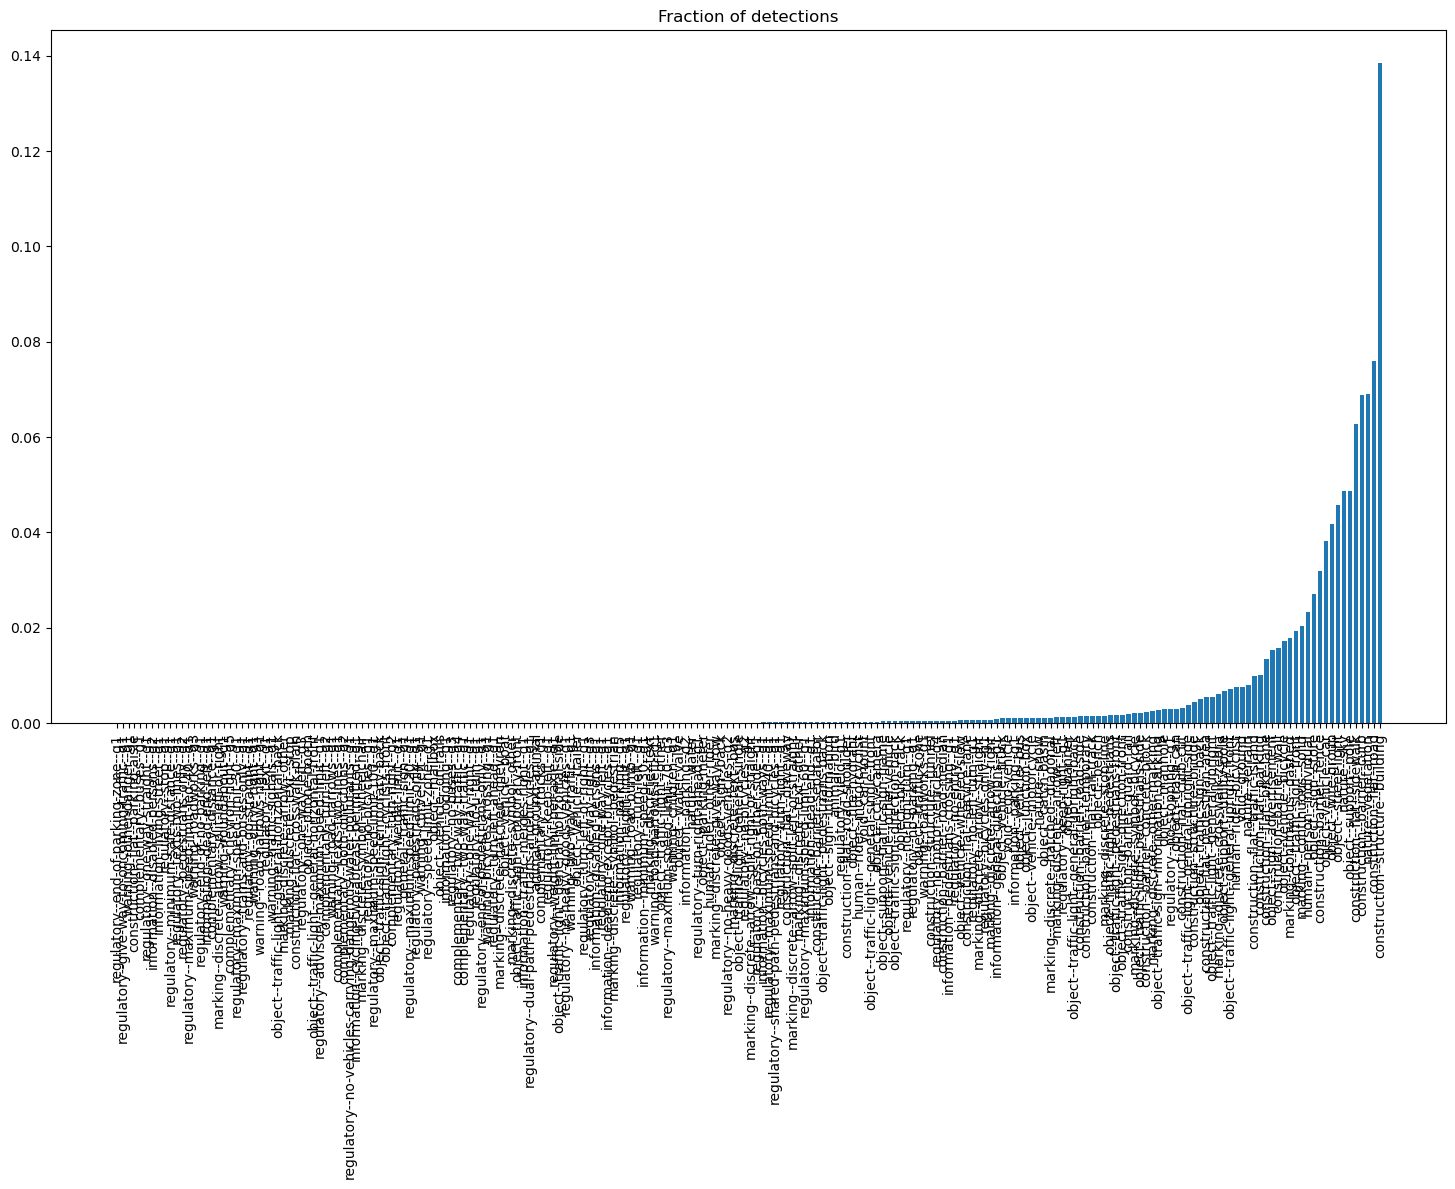

In [150]:
x_bar, y_bar = zip(*sorted_unique_occurrences)
y_bar = [x/sum(y_bar) for x in y_bar]
plt.figure(figsize=(18,9))
plt.bar(x_bar, y_bar)
plt.xticks(rotation = 90)
plt.title("Fraction of detections")
plt.show()

In [151]:

encounters = []
for keys in dict_image.keys():
    dab = count_occurrence(dict_image[keys])
    objects_found = list(dab.keys()) 
    encounters.append(objects_found)
encounters_tolist =  sum(encounters, [])
encounters_todict = count_occurrence(encounters_tolist)
sorted_unique_picture_encounters = sorted(encounters_todict.items(), key=lambda x:x[1])
    

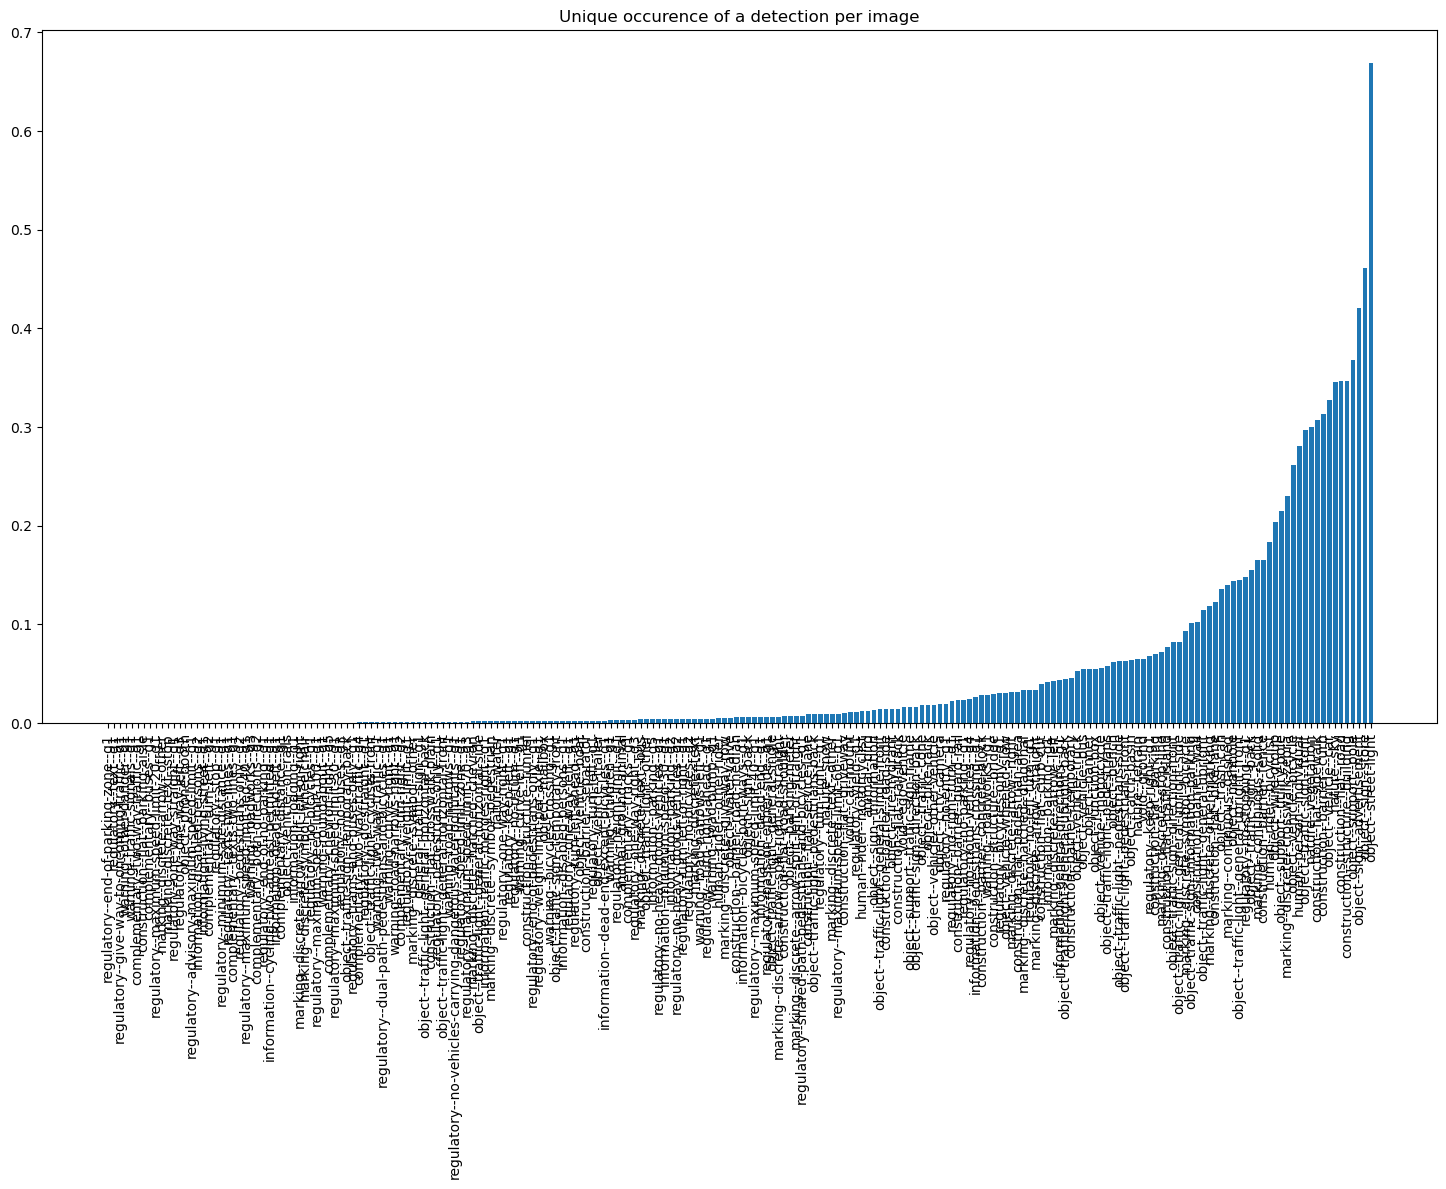

In [152]:
x_bar, y_bar = zip(*sorted_unique_picture_encounters)
y_bar = [x/len(dict_image) for x in y_bar]
plt.figure(figsize=(18,9))
plt.bar(x_bar, y_bar)
plt.xticks(rotation = 90)
plt.title("Unique occurence of a detection per image")
plt.show()

## Creating DataFrame with Data for Tree Model

In [153]:
#Loop over detections and create dictionaries, which can be manipulated for the creation of pd.dataframes

detections_per_image = []
dict_image_ids = []
image_ids = list(dict_image.keys())
for id in image_ids:
    dict_image_ids.append({'image_id': '{}'.format(id)})
    detections = count_occurrence(dict_image[id])
    detections_per_image.append(detections)

df_detections = pd.DataFrame.from_dict(detections_per_image)
df_image_ids = pd.DataFrame.from_dict(dict_image_ids)

#Concatenate the two dataframes containing detections per image and the image ID
image_detections = pd.concat([df_image_ids,df_detections], axis = 1)

#Assigning image ID's to edge ID's through pandas join functions
nonna_pointInPoly = pointInPoly.dropna()
df_image_edge = nonna_pointInPoly[["ID_left","ID_right"]]
df_image_edge = df_image_edge.rename(columns={'ID_left':'image_id', 'ID_right':'edge_id'})
merged_df = pd.merge(image_detections,df_image_edge, on = 'image_id')

#Lastly joining the activity from strava for the creation of the full dataset: |image_ids|detections|edge_id|#people|
df_activity = activity_df.rename(columns={'ID':'edge_id'})
data =  pd.merge(merged_df, df_activity, on='edge_id')

#Move edge_id column to location 0
edge_id_column = data.pop('edge_id')
data.insert(0, "edge_id", edge_id_column)
#Replace NaN with 0
data = data.fillna(0)

#Dataframe now looks like: |edge_id|image_ids|detections|#people|
print(data)

          edge_id          image_id  object--sign--store  \
0     174474089.0  1225822924515253                 22.0   
1     174474089.0  1396829457349707                  2.0   
2     174474089.0  2846377645611167                  4.0   
3     174474074.0  1225822924515253                 22.0   
4     174474074.0  1396829457349707                  2.0   
...           ...               ...                  ...   
2042  174476923.0  6032278833461286                  2.0   
2043  174476011.0  6254587191220991                 24.0   
2044  174475768.0  7496791067005134                  2.0   
2045  174475669.0  9079294525421585                  0.0   
2046  174475642.0  9079294525421585                  0.0   

      object--street-light  construction--barrier--curb  \
0                      2.0                          0.0   
1                      2.0                          0.0   
2                      2.0                          0.0   
3                      2.0                 

## Pop columns of detections that dont appear in atleast 5% of the pictures

In [154]:
#Identify detections that are over 5%
df_unique_detections=pd.DataFrame(list(zip(x_bar,y_bar)),columns=['detection','occurence'])
df_unique_detections = df_unique_detections[df_unique_detections['occurence'] >= 0.05]
detections_of_interest = df_unique_detections['detection'].to_list()
#Now we have a list with the detections that we are interested in. We insert the coloumn names for edge ID, image ID 
#and activity to get that from our data dataframe
detections_of_interest.insert(0, 'edge_id')
detections_of_interest.insert(1, 'image_id')
detections_of_interest.append('Activity')
#Thus getting the desired columns for our data
data = data[detections_of_interest]

## Take average of detections for an specific edge

In [155]:
averaged_data = data
averaged_data = averaged_data.loc[:, averaged_data.columns != 'image_id']
averaged_data = averaged_data.loc[:, averaged_data.columns != 'Activity']
averaged_data=averaged_data.groupby('edge_id').mean().reset_index()
print(averaged_data)

         edge_id  object--vehicle--truck  object--vehicle--bus  \
0    174472494.0                     0.0                   0.0   
1    174472497.0                     0.0                   0.0   
2    174472500.0                     0.0                   0.0   
3    174472501.0                     0.0                   0.0   
4    174472502.0                     0.0                   0.0   
..           ...                     ...                   ...   
787  174477402.0                     0.0                   1.5   
788  174477403.0                     0.0                   1.0   
789  174477404.0                     0.0                   0.0   
790  174477405.0                     0.0                   0.0   
791  174477478.0                     0.0                   0.0   

     object--banner  object--junction-box  object--vehicle--motorcycle  \
0               0.0                   0.0                          0.0   
1               0.0                   0.0                  

## Joining everything together

In [156]:
data_without_image_ids = data.loc[:, data.columns != 'image_id']
data_with_average_detections = pd.merge(averaged_data, df_activity, on='edge_id')
print(data_with_average_detections)

         edge_id  object--vehicle--truck  object--vehicle--bus  \
0    174472494.0                     0.0                   0.0   
1    174472497.0                     0.0                   0.0   
2    174472500.0                     0.0                   0.0   
3    174472501.0                     0.0                   0.0   
4    174472502.0                     0.0                   0.0   
..           ...                     ...                   ...   
787  174477402.0                     0.0                   1.5   
788  174477403.0                     0.0                   1.0   
789  174477404.0                     0.0                   0.0   
790  174477405.0                     0.0                   0.0   
791  174477478.0                     0.0                   0.0   

     object--banner  object--junction-box  object--vehicle--motorcycle  \
0               0.0                   0.0                          0.0   
1               0.0                   0.0                  

edge_id|image_id|detections|#people (structure of the data)

Average detections per edge ID vs. Each image per edge ID. It could be better to look at the average, as a very long edge would result in diverse detections and be an outlier.